In [ ]:
# default_exp core

In [24]:
%load_ext autoreload
%autoreload 2

# MOF core class

> API details.

In [2]:
#export
from pymatgen import Structure, Molecule
from pymatgen.analysis.graphs import StructureGraph
from pymatgen.analysis.local_env import JmolNN
import networkx as nx
import os
import matplotlib.pylab as plt
from copy import deepcopy
import nglview
from moffragmentor.sbu import Linker, Node

In [3]:
#export
def get_subgraphs_as_molecules(
    structure_graph: StructureGraph, use_weights=False
):
    """Copied from
    http://pymatgen.org/_modules/pymatgen/analysis/graphs.html#StructureGraph.get_subgraphs_as_molecules
    and removed the duplicate check
    Args:
        structure_graph ( pymatgen.analysis.graphs.StructureGraph): Structuregraph
    Returns:
        List: list of molecules
    """
    # ideally, we flag those atoms that are connected to the metals in some special way and make sure 
    # this gets propagated 
    
    # creating a supercell is an easy way to extract
    # molecules (and not, e.g., layers of a 2D crystal)
    # without adding extra logic
    supercell_sg = structure_graph * (3, 3, 3)

    # make undirected to find connected subgraphs
    supercell_sg.graph = nx.Graph(supercell_sg.graph)

    # find subgraphs
    all_subgraphs = [
        supercell_sg.graph.subgraph(c)
        for c in nx.connected_components(supercell_sg.graph)
    ]

    # discount subgraphs that lie across *supercell* boundaries
    # these will subgraphs representing crystals
    molecule_subgraphs = []
    for subgraph in all_subgraphs:
        intersects_boundary = any(
            [d["to_jimage"] != (0, 0, 0) for u, v, d in subgraph.edges(data=True)]
        )
        if not intersects_boundary:
            molecule_subgraphs.append(nx.MultiDiGraph(subgraph))

    # add specie names to graph to be able to test for isomorphism
    for subgraph in molecule_subgraphs:
        for node in subgraph:
            subgraph.add_node(node, specie=str(supercell_sg.structure[node].specie))

    # get Molecule objects for each subgraph
    molecules = []
    indices = []
    
    unique_subgraphs = []
    
    def node_match(n1, n2):
        return n1["specie"] == n2["specie"]

    def edge_match(e1, e2):
        if use_weights:
            return e1["weight"] == e2["weight"]
        else:
            return True

        
    for subgraph in molecule_subgraphs:

        already_present = [nx.is_isomorphic(subgraph, g,
                                            node_match=node_match,
                                            edge_match=edge_match)
                           for g in unique_subgraphs]

        if not any(already_present):
            unique_subgraphs.append(subgraph)
                
    
    def make_mols(molecule_subgraphs=molecule_subgraphs, center=False):
        molecules = []
        indices = []
        for subgraph in molecule_subgraphs:
            coords = [supercell_sg.structure[n].coords for n in subgraph.nodes()]
            species = [supercell_sg.structure[n].specie for n in subgraph.nodes()]
            binding = [supercell_sg.structure[n].properties['binding'] for n in subgraph.nodes()]
            idx = [n for n in subgraph.nodes()]
            molecule = Molecule(species, coords, site_properties={'binding': binding})

            # shift so origin is at center of mass
            if center:
                molecule = molecule.get_centered_molecule()
            indices.append(idx)
            molecules.append(molecule)
        return molecules, indices
    
#     molecules, indices = make_mols(molecule_subgraphs)
    molecules_unique, _ = make_mols(unique_subgraphs, center=True)
    
    return molecules_unique

In [4]:
#export
class MOF:
    def __init__(self, structure: Structure, structure_graph: StructureGraph):
        self.structure = structure
        self.structure_graph = structure_graph
        self._node_indices = None
        self._linker_indices = None 
        self.nodes = []
        self.linker = []
        
    @classmethod
    def from_cif(cls, cif): 
        s = Structure.from_file(cif)
        sg = StructureGraph.with_local_env_strategy(s, JmolNN())
        return cls(s, sg)
        
    @property
    def adjaceny_matrix(self):
        return nx.adjacency_matrix(self.structure_graph.graph)
    
    def show_adjacency_matrix(self, highlight_metals=False):
        matrix = self.adjaceny_matrix.todense()
        if highlight_metals: 
            cols = np.nonzero(matrix[self.metal_indices, :]) 
            rows = np.nonzero(matrix[:, self.metal_indices])
            matrix[self.metal_indices, cols] = 2
            matrix[rows, self.metal_indices] = 2
        plt.imshow(self.adjaceny_matrix.todense(), cmap='Greys_r')
    
    @property
    def metal_indices(self):
        return [
            i for i, species in enumerate(self.structure.species) if species.is_metal
        ]
    
    def get_neighbor_indices(self, site: int): 
        return [site.index for site in self.structure_graph.get_connected_sites(site)]
    
    def get_symbol_of_site(self, site: int): 
        return str(self.structure[site].specie)

    
    @property
    def node_indices(self): 
        if self._node_indices is None:
            node_indices = self._get_node_indices() 
        else: 
            node_indices = self._node_indices 
        
        return node_indices
    
    @property
    def linker_indices(self):
        node_indices = self.node_indices 
        
        return set(range(len(self.structure))) - node_indices
    
    def _label_site(self, site: int): 
        self.structure[site].properties = {'binding': True}
        
    def _label_structure(self):
        """Label node and linker atoms that are connected"""
        for metal_idx in self.metal_indices: 
            neighbor_indices = self.get_neighbor_indices(metal_idx)
            for neighbor_idx in neighbor_indices:
                if neighbor_idx in self.linker_indices:
                    self._label_site(metal_idx)
                    self._label_site(neighbor_idx)
                    
    def _fragment(self): 
        self._label_structure()
        sg0 = deepcopy(self.structure_graph)
        sg1 = deepcopy(self.structure_graph)
        sg0.remove_nodes(list(mof.linker_indices))
        sg1.remove_nodes(list(mof.node_indices))
        nodes_ = get_subgraphs_as_molecules(sg0)
        linkers_ = get_subgraphs_as_molecules(sg1)
        linkers = [Linker.from_labled_molecule(l) for l in linkers_]
        nodes = [Linker.from_labled_molecule(n) for n in nodes_]
        
        self.nodes = nodes 
        self.linkers = linkers
        return linkers, nodes
    
    def fragment(self):
        return self._fragment()
                    
    def _get_node_indices(self):
        # make a set of all metals and atoms connected to them:
        metals_and_neighbor_indices = set()
        node_atom_set=set(self.metal_indices)

        for metal_index in self.metal_indices:
            metals_and_neighbor_indices.add(metal_index)
            bonded_to_metal= self.get_neighbor_indices(metal_index)
            metals_and_neighbor_indices.update(bonded_to_metal)

        # add atoms that are only connected to metal or hydrogen to the node list 
        # + hydrogen atoms connected to them
        for index in metals_and_neighbor_indices:
            neighboring_indices=self.get_neighbor_indices(index)
            only_bonded_metal_hydrogen = True
            for index in neighboring_indices:
                if not (self.get_symbol_of_site(index) == 'H') or (index in node_atom_set):
                    only_bonded_metal_hydrogen = False
            if only_bonded_metal_hydrogen:
                node_atom_set.update(set([index]))

        for index in node_atom_set:
            for neighbor_index in self.get_neighbor_indices(index):
                if self.get_symbol_of_site(neighbor_index) == 'H':
                    node_atom_set.update(set(val))
        
        self._node_indices = node_atom_set
        return node_atom_set


In [5]:
# Create this class manually 
s = Structure.from_file(os.path.join('test_files', 'hkust1.cif'))
sg = StructureGraph.with_local_env_strategy(s, JmolNN())

mof = MOF(s, sg)

# use the classmethod
mof2 = MOF.from_cif(os.path.join('test_files', 'hkust1.cif'))

assert mof.metal_indices == mof2.metal_indices == [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

We can also plot the adjacency matrix

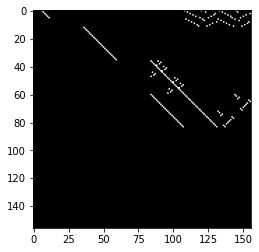

In [6]:
mof.show_adjacency_matrix()

To split a `MOF` into nodes and linkers we use the `fragment` method which will return lists of `Linker`

In [7]:
linkers, nodes = mof.fragment()

/Users/kevinmaikjablonka/opt/miniconda3/envs/pymoffragmentor/lib/python3.8/site-packages/pymatgen/core/structure.py:759: UserWarning: Not all sites have property binding. Missing values are set to None.
  warnings.warn(


In [8]:
linkers[0].show_molecule()

NGLWidget()

In [9]:
nodes[0].show_molecule()

NGLWidget()

In [10]:
from nbdev.export import notebook2script; notebook2script()

Converted 00_core.ipynb.
Converted 01_sbu.ipynb.
Converted index.ipynb.
